In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
start = dt.datetime(2014,1,1)
end = dt.datetime(2015,12,31)
benchmark = '000300.XSHG'
prices = get_price(benchmark, start_date=start, end_date=end, fields='ClosingPx')
returns = pd.DataFrame(np.log(prices).diff().dropna())
returns.rename(columns={'ClosingPx':'Log Return Rate'}, inplace=True)

In [3]:
# 检验收益率序列的平稳性
from statsmodels.tsa.stattools import adfuller
returns_array_like = [x for l in returns.values for x in l]
_, pvalue, *_ = adfuller(returns_array_like)
print ('pvalue :',pvalue)

pvalue : 1.81283251617e-06


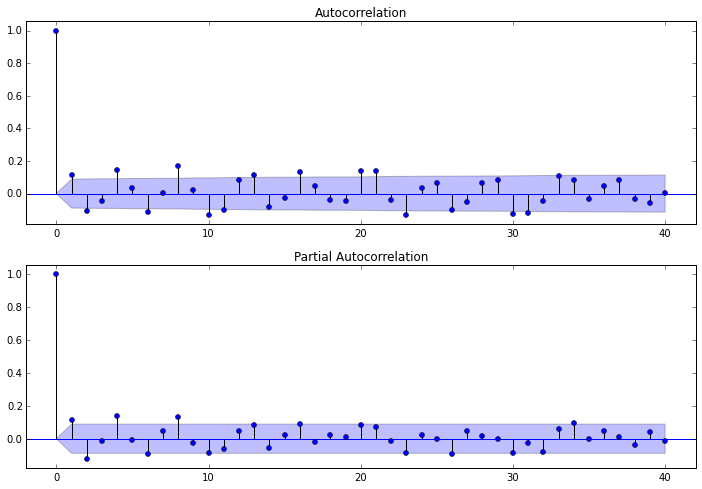

In [4]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returns.values, lags=40, alpha=0.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(returns.values, lags=40, alpha=0.05, ax=ax2);

由于ARMA模型不能简单的根据ACF和PACF的截尾简单地判断，所以我们这里不依据图像确定阶数，而且即使依赖图形也无法很好地确定

In [5]:
import  statsmodels.tsa.stattools as sts
resid = sts.arma_order_select_ic(returns, max_ar=4, max_ma=4, 
                                 ic=['aic','bic','hqic'], trend='nc', fit_kw=dict(method='css'))
print ('AIC-order :{}'.format(resid.aic_min_order))
print ('BIC-order :{}'.format(resid.bic_min_order))
print ('HQIC-order :{}'.format(resid.hqic_min_order))

/srv/env/lib64/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/srv/env/lib64/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC-order :(2, 4)
BIC-order :(0, 1)
HQIC-order :(2, 2)


/srv/env/lib64/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


本着降低模型复杂度的考虑，我们依据BIC准则进行建模
通过BIC（贝叶斯信息准则），给出的最优阶数是(0, 1),为此我们知道沪深300指数收益率序列可以直接由MA(1)模型刻画

In [6]:
# 在确定好ARMA模型的阶数后，我们来估计其参数

arma_mod01 = sm.tsa.ARMA(returns, (0, 1)).fit()   
print (arma_mod01.summary())
print ('-------------------------------------')
print (arma_mod01.params)


                              ARMA Model Results                              
Dep. Variable:        Log Return Rate   No. Observations:                  488
Model:                     ARMA(0, 1)   Log Likelihood                1228.890
Method:                       css-mle   S.D. of innovations              0.020
Date:                Thu, 23 Jun 2016   AIC                          -2451.781
Time:                        07:33:55   BIC                          -2439.210
Sample:                    01-03-2014   HQIC                         -2446.843
                         - 12-31-2015                                         
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                     0.0010      0.001      0.958      0.339        -0.001     0.003
ma.L1.Log Return Rate     0.1421      0.048      2.932      0.004         0.047     0.237
        

In [7]:
#为了进一步检验所构建模型的合理性，我们这里对收益率的残差进行自相关性检验

from statsmodels.stats import diagnostic
resid = arma_mod01.resid
_, pvalue, _, bppvalue = diagnostic.acorr_ljungbox(resid, lags=None, boxpierce=True)
print (pvalue,'\n',bppvalue)

[  7.86913837e-01   9.40923337e-02   1.15160562e-01   2.74076362e-03
   5.15661433e-03   6.05217068e-04   1.31039535e-03   1.01137128e-05
   2.17039446e-05   2.36870399e-06   8.85104582e-07   5.15723912e-07
   7.76641755e-08   2.90609637e-08   5.01442272e-08   3.28355809e-09
   5.60514043e-09   9.27749759e-09   1.00660493e-08   8.41667489e-10
   8.02950108e-11   1.30687399e-10   9.12301415e-12   1.30035911e-11
   9.43602777e-12   2.13448298e-12   2.99055566e-12   3.00697071e-12
   1.15556805e-12   9.66836251e-14   3.26197179e-14   4.23771590e-14
   9.50122055e-15   6.75580902e-15   8.82649126e-15   1.29717752e-14
   6.62204909e-15   1.04197625e-14   1.25329849e-14   2.47097856e-14] 
 [  7.87551456e-01   9.59181970e-02   1.17728833e-01   2.96487314e-03
   5.56887031e-03   6.86076813e-04   1.47706817e-03   1.29066655e-05
   2.75445899e-05   3.24383692e-06   1.26891780e-06   7.65637445e-07
   1.25439265e-07   4.96639691e-08   8.56709593e-08   6.42575957e-09
   1.09708777e-08   1.81755407e

我们发现残差基本是不相关的，尤其是在三阶以后，显著不相关，所以收益率模型的设定是比较合理的

In [8]:
# 在检验完残差的自相关性后，我们现在来考虑残差是否具有ARCH效应，从而更好地对收益率的波动率建模

*_, fpvalue = diagnostic.het_arch(resid)
print (fpvalue)

6.48155789518e-12


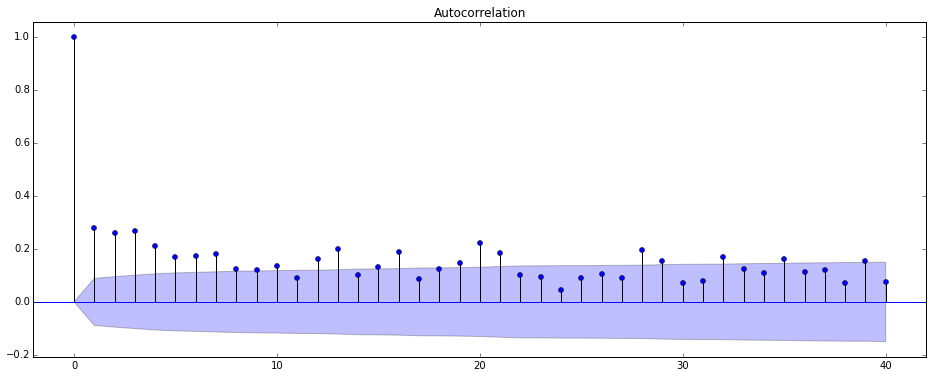

In [9]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(resid.values ** 2, lags=40, ax=ax1)

检验ARCH效应的原假设是不存在异方差性，根据检验结果我们可以发现收益率的残差项存在显著的异方差性，为了更直观地感受我们画出残差平方的自相关图

现在我们可以对收益率的波动率进行建模了，为了方便我们这里借助第三方模块来帮助我们实现想法

但是我们知道在金融时间序列分析中，资产收益率通常不是服从正态分布的，这里我们可以简单地检验一下

在此基础上，待会建模对分布进行设定时我们使用更加合理的学生t分布来取代默认的正太分布，当然学生t分布也并不能完全刻画资产收益率的尖峰厚尾现象

In [10]:
from statsmodels.stats.stattools import jarque_bera
_, jbpv, *_ = jarque_bera(returns.values)
print ('pvalue-->',jbpv)

pvalue--> [  5.30287710e-92]


In [11]:
from arch import arch_model
from arch.univariate import ZeroMean, GARCH, StudentsT, ConstantMean

arch_mod = ConstantMean(returns)
arch_mod.volatility = GARCH(1,0,1)
arch_mod.distribution = StudentsT()

res = arch_mod.fit(update_freq=5, disp='off')
print (res.summary())
print (' ')
print ('The estimated parameters: ')
print ('----------------------------------------')
print (res.params)

                        Constant Mean - GARCH Model Results                         
Dep. Variable:              Log Return Rate   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                1333.08
Distribution:      Standardized Student's t   AIC:                          -2656.15
Method:                  Maximum Likelihood   BIC:                          -2635.20
                                              No. Observations:                  488
Date:                      Thu, Jun 23 2016   Df Residuals:                      483
Time:                              07:33:56   Df Model:                            5
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

建模到这里就告一段落了，我们将相应的图形显示出来以方便我们直觉上的认知

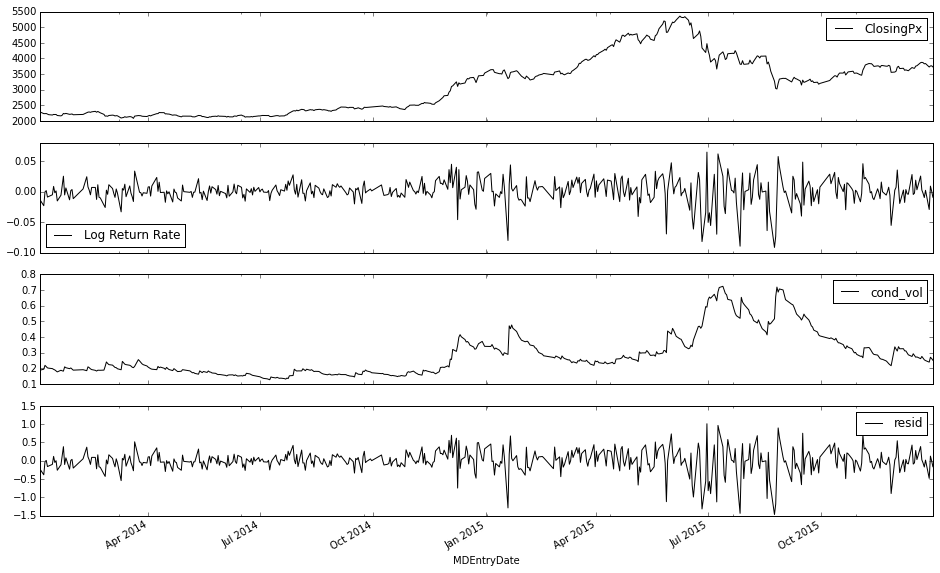

In [12]:
pd.DataFrame(prices[1:]).join(pd.DataFrame(returns)).join(np.sqrt(252) * pd.DataFrame(res.conditional_volatility).
                                                          join(pd.DataFrame(res.resid))).plot(figsize=(16, 10), subplots=True ,color='k');

在参数估计出来后，我们开始利用所估计出来的参数进行一步提前估计，来预测明天的收益率，从而提前对明天的投资决策做判断

我们在这里写出均值方程和波动率方程的形式，为了更直观地理解接下来的预测过程

\begin{eqnarray}
   r_t    & = & \mu + \epsilon_t + \theta\epsilon_{t-1} \\
   \epsilon_t & = & \sigma_t e_t \\
   \sigma^2_t & = & \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma^2_{t-1}
\end{eqnarray}

首先我们需要估计出下一期的波动率，即sigma^2_{t+1}, 在此基础上估计出r_{t+1}

In [13]:
# 参数值
mu = arma_mod01.params[0]
theta = arma_mod01.params[1]

omega = res.params[1]
alpha = res.params[2]
beta = res.params[3]

#print (mu, theta, omega, alpha, beta)

In [14]:
# sigma_forecastorecast是sigma_t的下一期预测值,sigma_t是当前的波动率

sigma_t = res.conditional_volatility.ix[-1]
sigma_forecast = np.sqrt(omega + alpha * res.resid.ix[-1] ** 2 + beta * res.conditional_volatility.ix[-1] ** 2)

epsilon_t = sigma_t * np.random.standard_normal()
epsilon_forecast = sigma_forecast * np.random.standard_normal()

returns_forecast = mu + epsilon_forecast + theta * epsilon_t
returns_forecast

-0.023200367701441398

In [15]:
# 假设依据现在的参数，预测出未来的10期收益率的值
def returns_predict(period):
    returns_pool = []
    for i in range(period):
        sigma_t = res.conditional_volatility.ix[-1]
        epsilon_t = sigma_t * np.random.standard_normal()
        
        sigma_forecast = np.sqrt(omega + alpha * epsilon_t ** 2 + beta * sigma_t ** 2)        
        epsilon_forecast = sigma_forecast * np.random.standard_normal()

        returns_forecast = mu + epsilon_forecast + theta * epsilon_t
        returns_pool.append(returns_forecast)
        sigma_t = sigma_forecast

    return returns_pool

returns_predict(5)

[-0.0021855133152268677,
 0.01847087322402725,
 -0.028159608570175364,
 -0.023493623876478284,
 0.020373308427950199]

当预测的收益率大于0时，则明天开盘买入，否则，开盘卖出
当然我们可以进一步细化交易策略，比如说如果高开大于预测的收益率，则卖出；若开盘跳空低开使得低于预测的收益率，则买入
下面我们进入到逻辑验证的回测阶段